## Otimização e Transfer Learning

In [2]:
import os
import requests
import zipfile

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, random_split
from torch import nn

from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_pil_image
import torchvision.models as models
from torchvision import datasets, transforms


## Aquecimento: Gradient Descent Manual (10 min)

Nesta primeira etapa, vamos **implementar do zero** o *gradient descent* de **apenas uma camada linear**, para compreender como funcionam os cálculos do **forward** (propagação direta) e do **backward** (retropropagação).

* Usaremos um **dataset bem pequeno** (5 pontos, 2 features) para que seja possível acompanhar os cálculos até mesmo **à mão**.
* Primeiro, faremos o **forward manual**, calculando as predições e a **função de perda** (MSE).
* Por fim, vamos **derivar manualmente os gradientes** de **W** e **b**, e atualizar os parâmetros passo a passo.

In [ ]:
X = torch.tensor([[1.0, 2.0],
                  [2.0, 3.0],
                  [3.0, 4.0],
                  [4.0, 5.0],
                  [5.0, 6.0]])

y = torch.tensor([[5.0],
                  [8.0],
                  [11.0],
                  [14.0],
                  [17.0]])

# Pesos e bias iniciais
W = torch.randn(2, 1, requires_grad=False)  # não usar autograd ainda
b = torch.randn(1, requires_grad=False)

Agora, implemente o forward e a loss (MSE) manualmente. Lembrando:


### **1. Forward pass**

A camada linear calcula:

$$
z = XW + b
$$


### **2. Função de perda**

Usaremos o **MSE** (*Mean Squared Error*):

$$
\text{Loss} = \frac{1}{N} \sum_{i=1}^N (z^{(i)} - y^{(i)})^2
$$

In [26]:
y_pred = None  
loss = None   

### **3. Backward pass**

Para obter os gradientes, vamos aplicar a **regra da cadeia** (*chain rule*) passo a passo para chegar em
$\frac{\partial \text{Loss}}{\partial W}$ e $\frac{\partial \text{Loss}}{\partial b}$. Lembrando:

$$
\frac{\partial \text{Loss}}{\partial W} = \frac{\partial Loss}{\partial z} \cdot \frac{\partial z}{\partial W}
$$


In [ ]:
grad_loss_z = None
grad_L_W = None
grad_L_b = None

Podemos validar os resultados, comparando com o autograd do PyTorch:

In [ ]:
W_ag = W.clone().detach().requires_grad_(True)
b_ag = b.clone().detach().requires_grad_(True)

y_pred_ag = X @ W_ag + b_ag
loss_ag = ((y_pred_ag - y) ** 2).mean()

loss_ag.backward()

print("Gradiente manual W:", grad_L_W.T) #.T só para facilitar a visualização
print("Gradiente autograd W:", W_ag.grad.T)
print("Gradiente manual b:", grad_L_b)
print("Gradiente autograd b:", b_ag.grad)

Gradiente manual W: tensor([[-62.4989, -80.5676]])
Gradiente autograd W: tensor([[-62.4989, -80.5676]])
Gradiente manual b: tensor(-18.0687)
Gradiente autograd b: tensor([-18.0687])


Finalmente, complete a lógica do `gradient descent` utilizando o código que fez acima e completando a atualização dos parâmetros:

In [ ]:
lr = 0.01
epochs = 10

losses = []
for epoch in range(epochs):

    # Forward 
    ## seu codigo ##

    # Gradientes manuais 
    ## seu codigo ##
    
    # Atualização dos parâmetros
    W = ## seu codigo ##
    b = ## seu codigo ##

    # Log simples
    losses.append(loss.item()) #salvando 
    print(f"Epoch {epoch+1}, Loss = {loss.item():.4f}")

print("\nPesos finais:\n", W)
print("Bias final:\n", b)
print("Previsões finais:\n", X @ W + b)

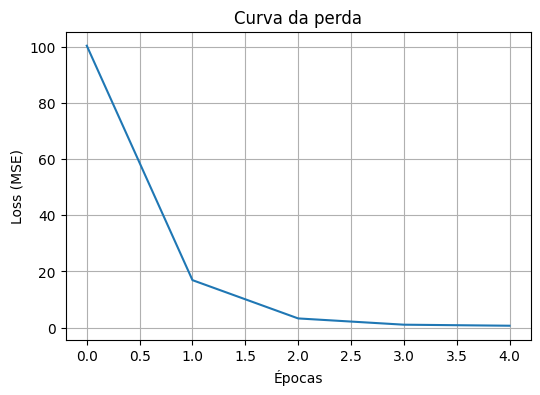

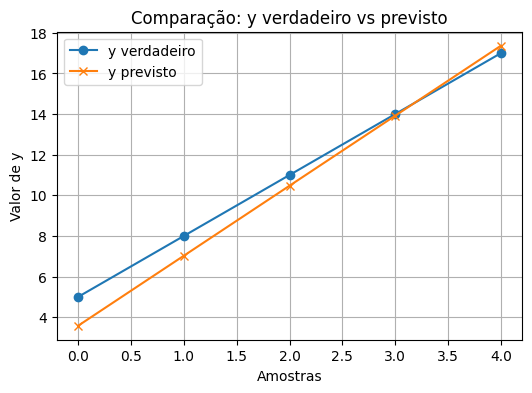

In [7]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.title("Curva da perda")
plt.grid(True)
plt.show()

# ---- PLOT 2: y verdadeiro vs previsto ----
plt.figure(figsize=(6,4))
plt.plot(y.numpy(), label="y verdadeiro", marker="o")
plt.plot(y_pred.detach().numpy(), label="y previsto", marker="x")
plt.xlabel("Amostras")
plt.ylabel("Valor de y")
plt.title("Comparação: y verdadeiro vs previsto")
plt.legend()
plt.grid(True)
plt.show()

#### resposta:

In [ ]:
# lr = 0.01
# epochs = 10
# losses = []
# for epoch in range(epochs):

#     # Forward 
#     y_pred = X @ W + b
#     loss = ((y_pred - y) ** 2).mean()
#     losses.append(loss.item()) #salvando 
    
#     # Gradientes manuais 
#     grad_loss_z = 2 * (y_pred - y) / y.size(0)   # dL/dz
#     grad_W = X.T @ grad_loss_z                   # dL/dW
#     grad_b = grad_loss_z.sum()                   # dL/db
    
#     # Atualização dos parâmetros
#     W -= lr * grad_W
#     b -= lr * grad_b

#     # Log simples
#     print(f"Epoch {epoch+1}, Loss = {loss.item():.4f}")

# print("\nPesos finais:\n", W)
# print("Bias final:\n", b)
# print("Previsões finais:\n", X @ W + b)

## Parte 1: Otimizadores (45 min)

Agora que entendemos como funciona o **gradient descent**, vamos usar o PyTorch para explorar diferentes **otimizadores** (Adam, SGD, RMSprop, Adagrad), e suas variações com Momentum e Nesterov, aplicados a uma **rede neural simples**. Com isso, poderemos comparar os diferentes algoritmos em termos da **tempo de convergência** e **acurácia do modelo**.

Aqui estou utilizando a mesma rede da aula passada, mas fique a vontade para implementar outra:

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

training_data = datasets.FashionMNIST(
    root="data", 
    train=True, 
    download=True, 
    transform=ToTensor()
    
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.flatten = nn.Flatten() #converte a imagem 28x28 em um vetor de 784 elementos
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), #aplica uma transformacao linear usando os pesos e bias armazenados
            nn.ReLU(), #ativação não-linear
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def loop_treino(dataloader, modelo, loss_fc, otimizador):

    modelo.train()
    total_loss = 0
    
    for X, y in dataloader:

        X, y = X.to(device), y.to(device)
        pred = modelo(X)
        loss = loss_fc(pred, y)

        otimizador.zero_grad()
        loss.backward()
        otimizador.step()
        
        total_loss += loss.item()
    return total_loss / len(dataloader)


def loop_teste(dataloader, modelo, loss_fc):

    modelo.eval()
    total_loss = 0
    corretas = 0

    with torch.no_grad():
        for  X,  y in dataloader:
            
            X, y = X.to(device), y.to(device)
            outputs = modelo(X)
            loss = loss_fc(outputs, y)
            total_loss += loss.item()

            pred = outputs.argmax(dim=1, keepdim=True)  # Obtém as previsões
            corretas += pred.eq(y.view_as(pred)).sum().item()

    return total_loss / len(dataloader), corretas / len(dataloader.dataset)

In [ ]:
batch_size = 64
epochs = 10

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

loss_fn = nn.CrossEntropyLoss()

Agora, vamos definir os otimizadores a serem testados. Algumas sugestões já estão abaixo, porém fique a vontade para modificar e testar as variações que quiser. 
Você pode consultar os algoritmos disponíveis no pytorch [aqui](https://docs.pytorch.org/docs/stable/optim.html#algorithms).

In [36]:
otimizadores = {
    "SGD (lr=0.01)": lambda params: torch.optim.SGD(params, lr=0.01),
    # "SGD + Momentum (lr=0.01)": lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9),
    # "Nesterov (lr=0.01)": lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True),
    "Adagrad (lr=0.01)": lambda params: torch.optim.Adagrad(params, lr=0.01),
    # "RMSProp (lr=0.01)": lambda params: torch.optim.RMSprop(params, lr=0.01),
    # "RMSProp (lr=0.1)": lambda params: torch.optim.RMSprop(params, lr=0.1),
    # "Adam (lr=0.01)": lambda params: torch.optim.Adam(params, lr=0.01),
    # "Adam (lr=0.0001)": lambda params: torch.optim.Adam(params, lr=0.0001),
    # "Adam (lr=0.1)": lambda params: torch.optim.Adam(params, lr=0.1),
    # "Adam (lr=0.3)": lambda params: torch.optim.Adam(params, lr=0.3),
    # "SGD (lr=0.3)": lambda params: torch.optim.SGD(params, lr=0.3),
    # "Adagrad (lr=0.3)": lambda params: torch.optim.Adagrad(params, lr=0.3),
    # "RMSProp (lr=0.3)": lambda params: torch.optim.RMSprop(params, lr=0.3),
}

E finalmente, treinar o modelo:

In [38]:
resultados = {}
for nome, otimizador_fn in otimizadores.items():
    
    print(f"\nTreinando com {nome}...")
    
    modelo = NeuralNetwork().to(device)
    otimizador = otimizador_fn(modelo.parameters())

    hist_treino, hist_teste, hist_acc = [], [], []

    for epoch in range(epochs):
        loss_train = loop_treino(train_dataloader, modelo, loss_fn, otimizador)
        loss_test, acc = loop_teste(test_dataloader, modelo, loss_fn)

        hist_treino.append(loss_train)
        hist_teste.append(loss_test)
        hist_acc.append(acc)

        print(f"Epoch {epoch+1}: treino_loss={loss_train:.4f}, teste_loss={loss_test:.4f}, acc={acc:.4f}")
    
    resultados[nome] = {"train": hist_treino, "test": hist_teste, "acc": hist_acc}



Treinando com SGD (lr=0.01)...
Epoch 1: treino_loss=1.2749, teste_loss=0.7887, acc=0.7278
Epoch 2: treino_loss=0.6778, teste_loss=0.6260, acc=0.7840
Epoch 3: treino_loss=0.5708, teste_loss=0.5588, acc=0.8017
Epoch 4: treino_loss=0.5162, teste_loss=0.5200, acc=0.8192
Epoch 5: treino_loss=0.4856, teste_loss=0.5294, acc=0.8064

Treinando com Adagrad (lr=0.01)...
Epoch 1: treino_loss=0.5026, teste_loss=0.4141, acc=0.8550
Epoch 2: treino_loss=0.3535, teste_loss=0.4501, acc=0.8379
Epoch 3: treino_loss=0.3163, teste_loss=0.3451, acc=0.8755
Epoch 4: treino_loss=0.2942, teste_loss=0.3365, acc=0.8789
Epoch 5: treino_loss=0.2778, teste_loss=0.3345, acc=0.8802


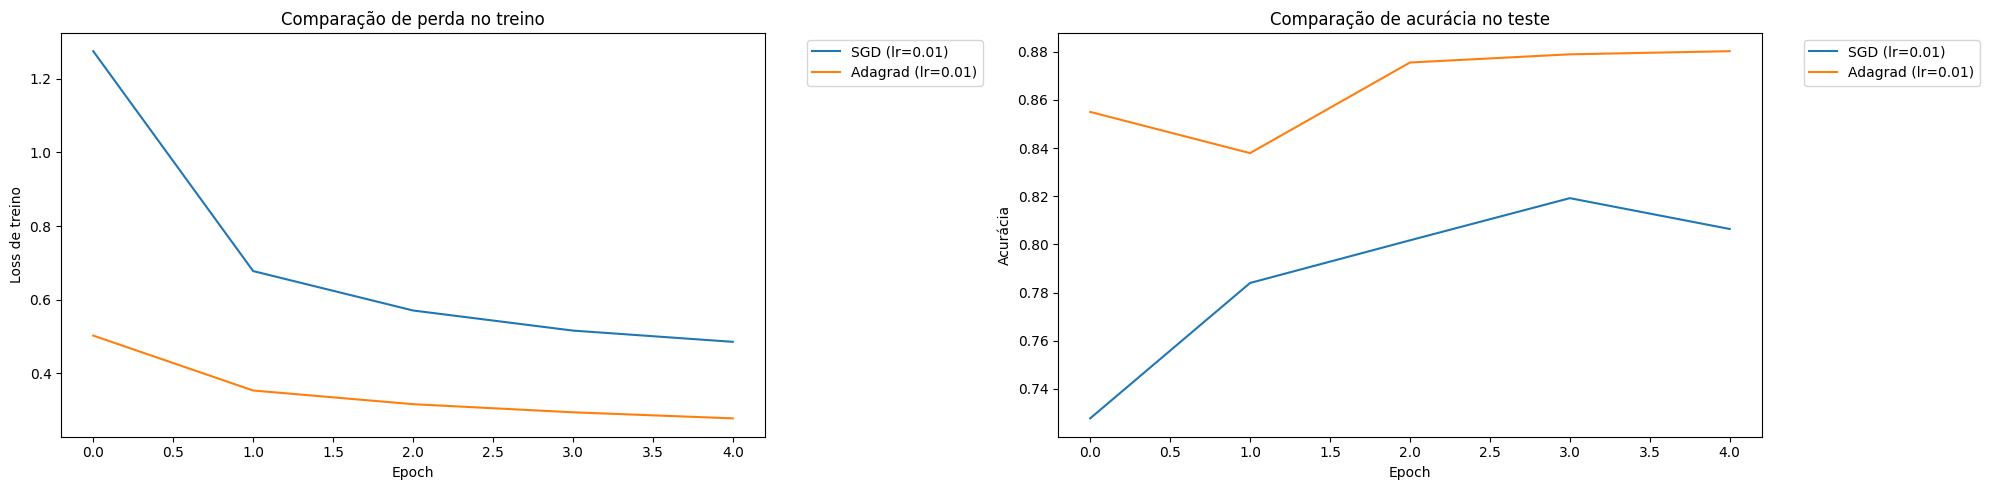

In [43]:
plt.figure(figsize=(20,5))

# Perda no teste
plt.subplot(1,2,1)
for nome, hist in resultados.items():
    plt.plot(hist["train"], label=nome)
plt.xlabel("Epoch")
plt.ylabel("Loss de treino")
plt.title("Comparação de perda no treino")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Acurácia no teste
plt.subplot(1,2,2)
for nome, hist in resultados.items():
    plt.plot(hist["acc"], label=nome)
plt.xlabel("Epoch")
plt.ylabel("Acurácia")
plt.title("Comparação de acurácia no teste")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Exercício 

Formule pelo menos uma pergunta ou hipótese sobre os otimizadores. Por exemplo:
- O que acontece quando a *learning rate* é muito alta para diferentes algoritmos?  
- Qual a diferença prática entre Momentum e Nesterov?  

Usando o código acima, faça experimentos que responda a sua pergunta. 
Depois, compartilhe pelo menos um resultado no [nesse issue do github](https://github.com/liviameinhardt/deep-learning-course-fgv/issues/1).


### Sugestões (para casa)
Teste outras variações do exercício em casa: altere o dataset, o modelo, etc. Se quiser, depois compartilhe no grupo ou github.

## Parte 2: Transfer Learning (45 min)

Nesta parte, vamos explorar o comportamento de **redes pré-treinadas** comparadas a redes com **pesos inicializados aleatoriamente**.  

- Usaremos a **[ResNet34](https://editor.analyticsvidhya.com/uploads/38371XTo6Q.png) pré-treinada no ImageNet** como base para entender a eficácia do *transfer learning*.  
- Vamos aplicar o conceito de **layer freezing**, treinando apenas alguns parâmetros para a nova tarefa.  



Começamos baixando o dataset:

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_path = 'cats_and_dogs_filtered.zip'
extract_path = 'cats_and_dogs_filtered'

# Download 
response = requests.get(_URL)
with open(zip_path, 'wb') as f:
    f.write(response.content)

# Extrair
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# Definir caminhos para os diretórios do conjunto de dados
train_dir = os.path.join(extract_path, 'train')
validation_dir = os.path.join(extract_path, 'validation')

print(f"Diretório dos dados de treinamento: {train_dir}")
print(f"Diretório dos dados de validação: {validation_dir}")
assert os.path.exists(train_dir), "Diretório de treinamento não existe."
assert os.path.exists(validation_dir), "Diretório de validação não existe."

Diretório dos dados de treinamento: cats_and_dogs_filtered\train
Diretório dos dados de validação: cats_and_dogs_filtered\validation


Agora carregamos e pré-processamos:

In [8]:
# Definição das transformações de dados

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data augmentation
data_augmentation = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),  # Flip horizontal com prob 0.5
    transforms.RandomRotation(degrees=20),  # Rotação aleatória entre -20 e 20 graus
    transforms.RandomResizedCrop(size=150, scale=(0.85, 1.0)),  # Recorte e redimensionamento aleatórios
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização
])

# Carrega os dados baixados
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_augmentation)
validation_dataset = datasets.ImageFolder(root=validation_dir, transform=transform)

# Definir tamanhos dos conjuntos de dados de validação e teste
val_size = len(validation_dataset)
test_size = val_size // 2
remaining_val_size = val_size - test_size

# Dividir o conjunto de validação em conjuntos de teste e validação restantes
test_dataset, remaining_val_dataset = random_split(validation_dataset, [test_size, remaining_val_size])

# Criar data loaders para os conjuntos de teste e validação restantes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
validation_loader = DataLoader(remaining_val_dataset, batch_size=32, shuffle=False)

Algumas amostras:

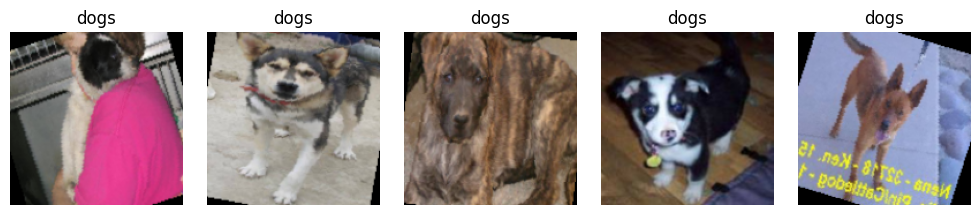

In [11]:
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean ).view(1, 3, 1, 1)
    std = torch.tensor( std).view(1, 3, 1, 1)
    tensor = tensor * std + mean
    return tensor

def imshow(img, title):
    img = to_pil_image(img)  # Convert tensor to PIL image
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

data_iter = iter(train_loader)
images, labels = next(data_iter)
class_names = train_dataset.classes
denormalized_images = denormalize(images, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
num_images = 5  # 5x5 grid

plt.figure(figsize=(10,6))  # Adjust figure size as needed
for i in range(num_images):
    plt.subplot(3, 5, i + 1)
    imshow(denormalized_images[i], class_names[labels[i]])
plt.tight_layout()
plt.show()

Finalmente, definimos a rede:

In [10]:

class ResNetTransferLearning(nn.Module):
    def __init__(self, num_classes, weights='IMAGENET1K_V1'): #use weights=None para treinar do zero
        super(ResNetTransferLearning, self).__init__()

        #carregar a arquitetura
        self.resnet = models.resnet34(weights=weights) 

        # Cria uma FC para classificação
        num_features = self.resnet.fc.in_features

        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),  # First dense layer
            nn.ReLU(),                    # Activation function
            nn.Dropout(0.5),              # Dropout layer
            nn.Linear(512, 256),          # Second dense layer
            nn.ReLU(),                    # Activation function
            nn.Linear(256, num_classes)   # Final output layer
        )

    def forward(self, x):
        return self.resnet(x)

    def freeze_until_layer(self, layer_name):
        """
        Freeze all parameters until the specified layer name.

        Parameters:
        - layer_name (str): The name of the layer until which parameters should be frozen.
        """
        layer_found = False

        # Iterar sobre as camadas do modelo
        for name, param in self.named_parameters():
            if layer_name in name:
                layer_found = True
            if not layer_found:
                param.requires_grad = False  # Congela as camadas até encontrar a desejada
            if layer_found:
                break  # Para de congelar quando encontra a camada


In [14]:
model = ResNetTransferLearning(num_classes=len(train_dataset.classes)).to(device)
print(model)

ResNetTransferLearning(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

Para congelar a rede até o layer 4.1, por exemplo, faríamos: `model.freeze_until_layer('layer4.1')`. Abaixo, os nomes dos layers:

In [15]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

resnet.conv1.weight True
resnet.bn1.weight True
resnet.bn1.bias True
resnet.layer1.0.conv1.weight True
resnet.layer1.0.bn1.weight True
resnet.layer1.0.bn1.bias True
resnet.layer1.0.conv2.weight True
resnet.layer1.0.bn2.weight True
resnet.layer1.0.bn2.bias True
resnet.layer1.1.conv1.weight True
resnet.layer1.1.bn1.weight True
resnet.layer1.1.bn1.bias True
resnet.layer1.1.conv2.weight True
resnet.layer1.1.bn2.weight True
resnet.layer1.1.bn2.bias True
resnet.layer1.2.conv1.weight True
resnet.layer1.2.bn1.weight True
resnet.layer1.2.bn1.bias True
resnet.layer1.2.conv2.weight True
resnet.layer1.2.bn2.weight True
resnet.layer1.2.bn2.bias True
resnet.layer2.0.conv1.weight True
resnet.layer2.0.bn1.weight True
resnet.layer2.0.bn1.bias True
resnet.layer2.0.conv2.weight True
resnet.layer2.0.bn2.weight True
resnet.layer2.0.bn2.bias True
resnet.layer2.0.downsample.0.weight True
resnet.layer2.0.downsample.1.weight True
resnet.layer2.0.downsample.1.bias True
resnet.layer2.1.conv1.weight True
resnet.l

Definindo a função de treinamento e avaliação:

In [20]:
def train_step(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_train += predicted.eq(labels).sum().item()
        total_train += labels.size(0)

    # Calculate average loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct_train / total_train

    return train_loss, train_accuracy

def evaluate(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    # Disable gradient calculations during evaluation
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    # Calculate average loss and accuracy
    val_loss = running_loss / len(data_loader)
    val_accuracy = 100. * correct_val / total_val

    return val_loss, val_accuracy

Também vamos definir uma classe para fazer Early Stopping do modelo:

In [27]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        """
        Arguments:
        - patience: How many epochs to wait after the last improvement before stopping the training.
        - delta: Minimum change in validation loss to consider as an improvement.
        - path: Path to save the best model.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.epochs_without_improvement = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1
            if self.epochs_without_improvement >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True


Definindo o treinamento:


In [ ]:
model = ResNetTransferLearning(num_classes=len(train_dataset.classes)).to(device) #passe weights=None para treinar do zero; default usa o imagenet
# model.freeze_until_layer('layer4') #exemplo de congelamento

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #fique livre para mudar também
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=10, delta=0.001)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 50

for epoch in range(num_epochs):

    train_loss, train_accuracy = train_step(model, train_loader, criterion, optimizer, device)

    #validando o modelo
    val_loss, val_accuracy = evaluate(model, validation_loader, criterion, device)
    
    # salva metricas
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    early_stopping(val_loss)

    # Checa se o early stopping foi ativado
    if early_stopping.early_stop:
        print("Early stopping at epoch", epoch+1)
        break

Epoch [1/5]
Train Loss: 0.4351, Train Accuracy: 79.90%
Validation Loss: 0.4727, Validation Accuracy: 80.60%
Epoch [2/5]
Train Loss: 0.3386, Train Accuracy: 86.45%
Validation Loss: 0.3934, Validation Accuracy: 81.00%
Epoch [3/5]
Train Loss: 0.3173, Train Accuracy: 86.80%
Validation Loss: 0.5211, Validation Accuracy: 80.20%
Epoch [4/5]
Train Loss: 0.2330, Train Accuracy: 90.75%
Validation Loss: 0.3598, Validation Accuracy: 88.80%
Epoch [5/5]
Train Loss: 0.2312, Train Accuracy: 91.55%
Validation Loss: 0.9847, Validation Accuracy: 69.20%


Mostrando os resultados:

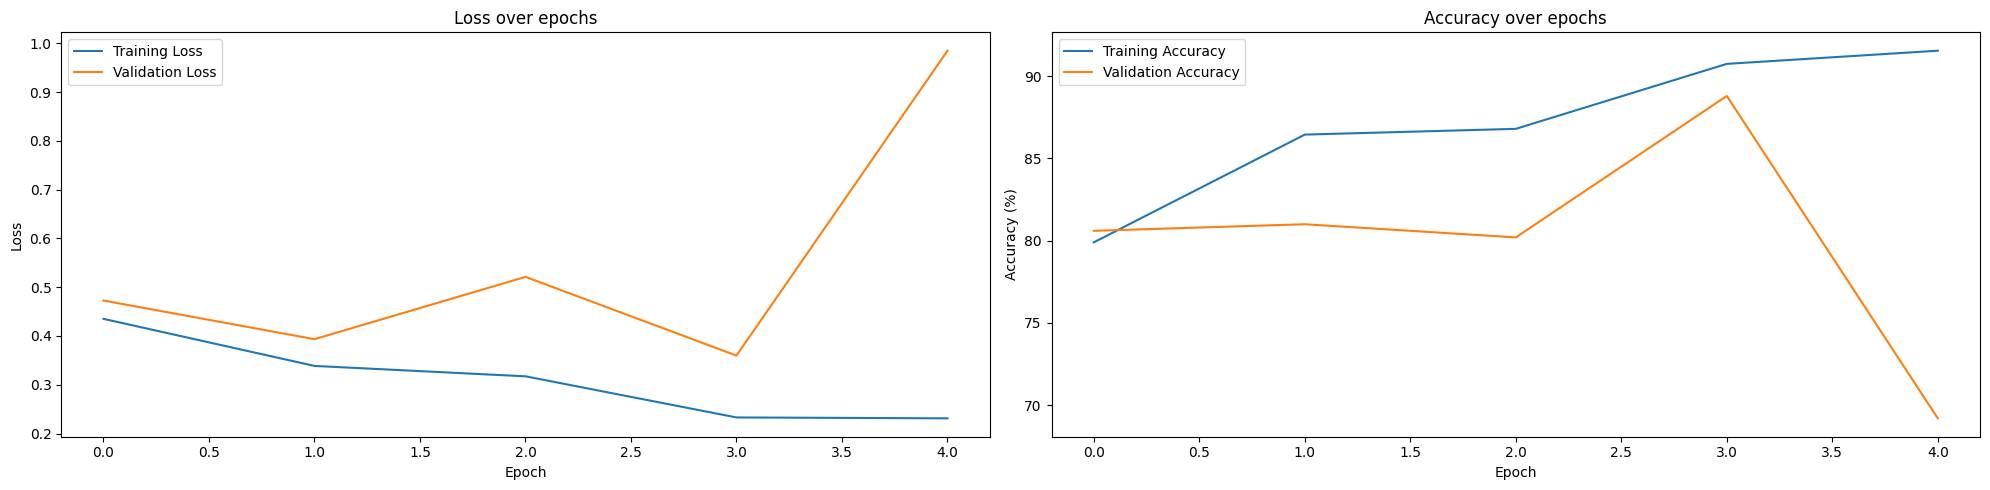

In [36]:
plt.figure(figsize=(20,5))

# Perda no teste
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Acurácia no teste
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

### Exercício:

1. Treine o modelo do zero (pesos inicializados aleatoriamente).
2. Treine o modelo **ResNet34 pré-treinado**.
3. Congele todas as camadas até `layer3.1` no modelo pré-treinado e faça o *fine-tuning* do restante.
4. Congele todas as camadas até `layer4.1` no modelo pré-treinado e faça o *fine-tuning* do restante.
5. Congele todas as camadas até a camada totalmente conectada (`fc`) no modelo pré-treinado e faça o *fine-tuning* dos parâmetros restantes.

Lembre de plotar o resultado de cada experimento. Fique livre para testar outros experimentos durante a aula ou depois. Ao finalizar, poste seus resultados e um breve comentário [nesse issue do github](https://github.com/liviameinhardt/deep-learning-course-fgv/issues/2)

## Avaliação

Deixe seu feedback da aula [aqui](https://forms.gle/DSZsGDpkaGi3f2FW7) por favor :)